<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet4_Corr%C3%A9lation_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Projet 4
OpenClassrooms - ENSAE-ENSAI

# Introduction

## **Mission 3 : les corrélations**

 **Une analyse de corrélation est une technique statistique qui fournit des informations sur le lien entre deux variables**
 exemple s'il existe un lien entre la taille du corps et la taille des chaussures.**

Nous allons répondre aux questions suivantes:

- Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?
- Y a-t-il une corrélation entre l'âge des clients et le montant total des achats ?
- Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (nombre d'achats par mois) ?
- Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles) ?
- Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés ?

## Importation des librairies

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import math as mth
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr, kendalltau
from scipy import stats


**Configuration Pandas**

In [ ]:

# Afficher toutes les colonnes sans troncature
pd.set_option("display.max_columns", None)
# Limiter le nombre de lignes affichées
pd.set_option("display.max_rows", 100)
# Formater les floats pour plus de lisibilité
pd.set_option("display.float_format", lambda x: "%.2f" % x)

**Configuration Matplotlib / Seaborn**

In [ ]:

# Style général des graphiques
sns.set_theme(style="whitegrid", palette="muted")
# Taille par défaut des graphiques
plt.rcParams["figure.figsize"] = (10, 6)
# Taille de police des titres et labels
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## Préparation des données

In [ ]:
#autorisation d'acces au google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Importation des données

In [ ]:
#importation des données depuis un ficher dans google drive
import os, glob

DATA_DIR = "/content/drive/MyDrive/Projet_P4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_final.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_final.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_final.csv


In [ ]:
# Masquer seulement les "SettingWithCopyWarning"
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

print(" Librairies importées et environnement configuré")

 Librairies importées et environnement configuré


In [ ]:
# Charger tous les CSV dans un dictionnaire
import pandas as pd
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

In [ ]:
#  Afficher un résumé de chaque CSV (nom + dimensions)
for name, df in dfs.items():
    print(f"{name}: {df.shape}")

transactions_clean.csv: (336713, 4)
customers_clean.csv: (8621, 4)
products_clean.csv: (3287, 3)
transactions_final.csv: (336713, 4)
customers_final.csv: (8621, 4)
products_final.csv: (3287, 3)


In [ ]:
#appeler et renommer les dataframes
df_customers_raw = dfs["customers_clean.csv"]
df_products_raw = dfs["products_clean.csv"]
df_transactions_raw = dfs["transactions_clean.csv"]

In [ ]:
# Copie de sécurité
df_transactions = df_transactions_raw.copy()
df_products = df_products_raw.copy()
df_customers = df_customers_raw.copy()

#Création de la mega DataFrame (df_tf)

In [ ]:
# Jointures de la "megadataframe" table de faits
df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,f,1980,45


In [ ]:
df_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336713 entries, 0 to 336712
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336713 non-null  object 
 1   date        336713 non-null  object 
 2   session_id  336713 non-null  object 
 3   client_id   336713 non-null  object 
 4   price       336713 non-null  float64
 5   categ       336713 non-null  int64  
 6   sex         336713 non-null  object 
 7   birth       336713 non-null  int64  
 8   age         336713 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 23.1+ MB


# Dans df_tf : convertit 'age' en numérique
df_tf["age"] = pd.to_numeric(df_tf["age"], errors="coerce")   # ex. '55' -> 55.0
df_tf["sex"] = df_tf["sex"].astype("category").cat.codes
df_tf["categ"] = df_tf["categ"].astype("category")
df_tf["date"] = pd.to_datetime(df_tf["date"])

| Méthode              | Type de relation mesurée                                              | Type de variables               | Hypothèses statistiques                          | Sensibilité aux valeurs extrêmes / distribution          | Interprétation                           |
| -------------------- | --------------------------------------------------------------------- | ------------------------------- | ------------------------------------------------ | -------------------------------------------------------- | ---------------------------------------- |
| **Pearson (r)**      | Relation **linéaire** entre deux variables continues                  | Quanti – Quanti                 | Linéarité, normalité, homogénéité de la variance | Très sensible aux valeurs extrêmes                       | Force et direction du lien linéaire      |
| **Spearman (ρ)**     | Relation **monotone** (croissante ou décroissante), même non linéaire | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Moins sensible aux outliers                              | Force et direction du lien monotone      |
| **Kendall (τ)**      | **Concordance / discordance** entre les rangs d’observations          | Quanti – Quanti (ou ordinale)   | Aucune normalité requise                         | Très robuste aux valeurs extrêmes et petits échantillons | Probabilité de concordance des paires    |
| **Eta carré (η²)**   | **Part de variance expliquée** par une variable catégorielle          | Quali – Quanti                  | Homogénéité des variances (ANOVA)                | Peu sensible aux valeurs extrêmes                        | Mesure l’intensité de l’effet (0 à 1)    |
| **Omega carré (ω²)** | Variante corrigée de η² (moins biaisée)                               | Quali – Quanti                  | Homogénéité des variances                        | Plus robuste que η²                                      | Part réelle de variance expliquée        |
| **Chi² (χ²)**        | Écart entre fréquences observées et attendues sous indépendance       | Quali – Quali                   | Effectifs suffisants, indépendance               | Sensible aux faibles effectifs                           | Teste l’existence d’un lien significatif |
| **Cramer’s V**       | **Association** entre deux variables catégorielles                    | Quali – Quali                   | Effectifs suffisants (>5 par cellule)            | Robuste si N grand                                       | Intensité de l’association (0 à 1)       |
| **Phi (φ)**          | Corrélation entre deux variables **binaires**                         | Quali – Quali (binaire–binaire) | Effectifs suffisants                             | Sensible aux déséquilibres de fréquence                  | Équivalent du χ² normalisé (0–1)         |
| **Tschuprow’s T**    | Variante symétrique de Cramer’s V pour tables rectangulaires          | Quali – Quali                   | Effectifs suffisants                             | Stable sur tables non carrées                            | Association entre modalités non carrées  |


| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**                            |
| Une variable catégorielle et une numérique                  | **η²** ou **ω²**                                               |
| Deux variables catégorielles                                | **Cramer’s V** ou **χ²**                                       |
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |


In [ ]:
# Dans df_tf : convertit 'age' en numérique
df_tf["age"] = pd.to_numeric(df_tf["age"], errors="coerce")   # ex. '55' -> 55.0
df_tf["sex"] = df_tf["sex"].astype("category").cat.codes
#df_tf["categ"] = df_tf["categ"].astype("category")
#df_tf["date"] = pd.to_datetime(df_tf["date"])

In [ ]:
# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)

In [ ]:
df_tfc =df_tf.copy()

In [ ]:
# somme du montant total par session
montant_par_session = (
    df_tf.groupby("session_id", observed=True)["price"]
      .sum()
      .rename("montant_session")
)

# ajout dans ton DataFrame d’origine
df_tf = df_tf.join(montant_par_session, on="session_id")

df_tf.head()

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48,45-54,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25,25-34,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,0,1979,46,45-54,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,1,1963,62,55-64,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,0,1980,45,45-54,31.10


In [ ]:
df_tf["nb_achats"] = (
    df_tf.groupby("session_id")["id_prod"]
         .transform("size")          # nombre de lignes dans la session
)

In [ ]:
df_tf["montant_total_session"] = (
    df_tf.groupby("session_id")["price"]
         .transform("sum")           # somme des prix dans la session
)

In [ ]:
df_tf.head(2)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48,45-54,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25,25-34,184.26,2,184.26


# Corrélations : généralités

| Cas d’usage                                                 | Méthode à privilégier                                          |
| ----------------------------------------------------------- | -------------------------------------------------------------- |
| Deux variables numériques continues et linéaires            | **Pearson (r)**                                                |
| Deux variables numériques mais non linéaires ou ordinales   | **Spearman (ρ)** ou **Kendall (τ)**
| Relations complexes (non linéaires, interactions multiples) | **Distance correlation (dCor)** ou **régression non linéaire** |

In [ ]:
# choix des collones
cols = ["price", "age", "categ", "sex"]

df_corr = df_tf[cols]

In [ ]:
#Méthode .corr() avec la formule de la corrélation linéaire de Pearson
corr = df_corr.corr(method="pearson")
corr

,price,age,categ,sex
price,1.00,-0.21,0.67,0.01
age,-0.21,1.00,-0.10,-0.04
categ,0.67,-0.10,1.00,0.00
sex,0.01,-0.04,0.00,1.00


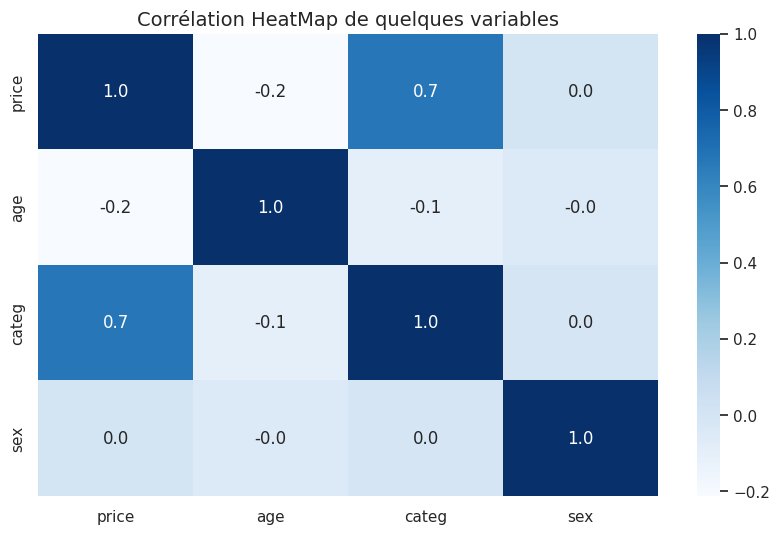

In [ ]:
sns.heatmap(df_corr.corr(), annot=True, fmt=".1f", cmap='Blues')
plt.title('Corrélation HeatMap de quelques variables')
plt.show()





L’analyse de la matrice de corrélation met en évidence plusieurs points clés :

**Lien entre birth et age**
La corrélation est parfaitement négative (−1.00), ce qui confirme que ces deux variables sont redondantes. Dans les analyses ultérieures, il suffira de conserver une seule de ces deux variables.

**Lien entre price et categ**
Une corrélation positive notable (+0.67) est observée : le prix tend à augmenter avec la catégorie. Ce résultat suggère un lien entre ces deux variables. Il faut cependant rappeler que l'encodage numerique de "categ" est arbitraire, donc ne represente pas un ordre naturel.

**Lien entre price et les variables d’âge** (birth, age)
Les corrélations sont faibles (≈ ±0.21), indiquant qu’il n’existe pas de lien significatif entre le prix et l’âge des individus.

**Lien entre categ et les variables d’âge** (birth, age)
Les corrélations sont très faibles (≈ ±0.10), ce qui montre l’absence de relation notable entre la catégorie et l’âge.

**Lien entre sex et les autres variables**
Les corrélations avec sex_num sont toutes proches de zéro (entre −0.04 et +0.04). Cela signifie que le sexe n’a pas d’influence détectable sur le prix, la catégorie ou l’âge des individus dans ce jeu de données.










## Corrélation entre le sexe des clients / catagéorie de produits(quali - quali)

| Méthode        | Type de relation mesurée                                                                | Hypothèses                                                                       | Sensibilité au bruit / valeurs extrêmes                      |
| -------------- | --------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------- | ------------------------------------------------------------ |
| **Chi² (χ²)**  | Écart entre fréquences observées et attendues sous hypothèse d’indépendance             | Effectifs suffisants (idéalement > 5 par cellule), indépendance des observations | Sensible aux faibles effectifs ou déséquilibres de fréquence |
| **Cramer’s V** | **Intensité de l’association** entre deux variables catégorielles (normalisée de 0 à 1) | Effectifs suffisants, dérivé du test du χ²                                       | Peu sensible aux déséquilibres modérés, robuste pour N élevé |
| **Phi (φ)**    | Corrélation pour **tables 2×2** (binaire–binaire), équivalent normalisé du χ²           | Effectifs suffisants et variables binaires                                       | Sensible aux déséquilibres de proportion entre catégories    |


In [ ]:
#table de contingence (tableau croisé) entre deux variables.
cont_table = pd.crosstab(df_tf["sex"], df_tf["categ"])
cont_table

categ,0,1,2
sex,,,
0,103786,55469,8260
1,105640,54266,9292


In [ ]:
#Création du tableau de contingence "Matrice des valeurs observées"
#Variables 'sex' et 'categ' du dataframe df
X = 'sex'
Y = 'categ'

#Calcul du tableau de contigence par la méthode .pivot_table()
c = df_tf[[X, Y]].pivot_table(index=X, columns=Y, aggfunc=len) ###, margins=True, margins_name='Total'
tx = df_tf[X].value_counts()
ty = df_tf[Y].value_counts()

#Création d'une copie du dataframe original
cont = c.copy()
cont

categ,0,1,2
sex,,,
0,103786,55469,8260
1,105640,54266,9292


In [ ]:
tx_df= pd.DataFrame(tx)
ty_df = pd.DataFrame(ty)

tx_df.columns = ["s"]
ty_df.columns = ["s"]

#Valeurs totales observées
n = len(df_tf)

#Produit matriciel. On utilise pd.T pour pivoter une des deux séries.
indep = (tx_df.dot(ty_df.T) / n)
indep

categ,0,1,2
sex,,,
1,105236.39,55141.75,8819.87
0,104189.61,54593.25,8732.13


In [ ]:
#Matrice "écart au carré normalisé de la valeur attendue VS valeur observée"
mesure = (c-indep)**2/indep
mesure

categ,0,1,2
sex,,,
0,1.56,14.05,25.53
1,1.55,13.91,25.27


In [ ]:
# Test du chi²
chi2, p, dof, expected = chi2_contingency(cont_table) #applique le test du chi² d’indépendance sur ton tableau de contingence. avec dof= degré de liberté

n = cont_table.sum().sum()
phi = np.sqrt(chi2/n)

print("Phi (sex ~ categ) :", phi) #[0,1] donne la force de l’association.
print("p-value :", p) #p_value du chi² indique si l’association est statistiquement significative.

Phi (sex ~ categ) : 0.015593036135551715
p-value : 1.6683997257127539e-18


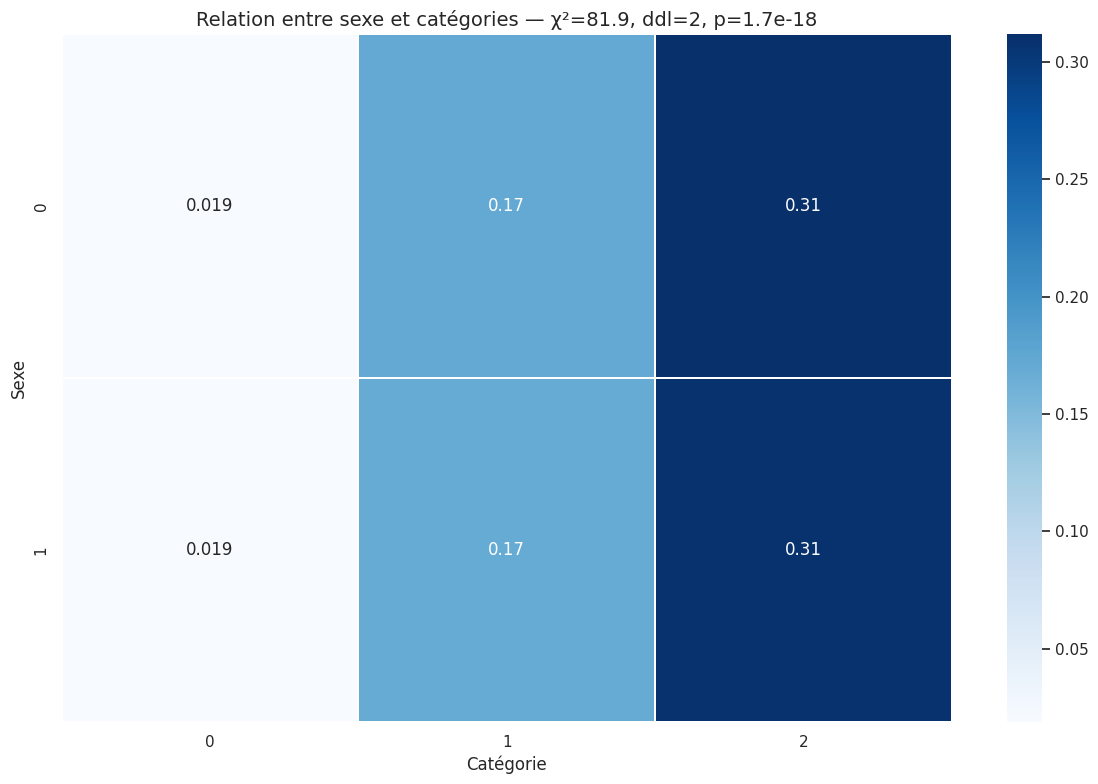

In [ ]:
table = (mesure/chi2)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(table, annot=True, cmap="Blues", linewidths=0.1)
ax.set_title(f"Relation entre sexe et catégories — χ²={chi2:.1f}, ddl={dof}, p={p:.2g}")
ax.set_xlabel("Catégorie"); ax.set_ylabel("Sexe")
plt.tight_layout(); plt.show()

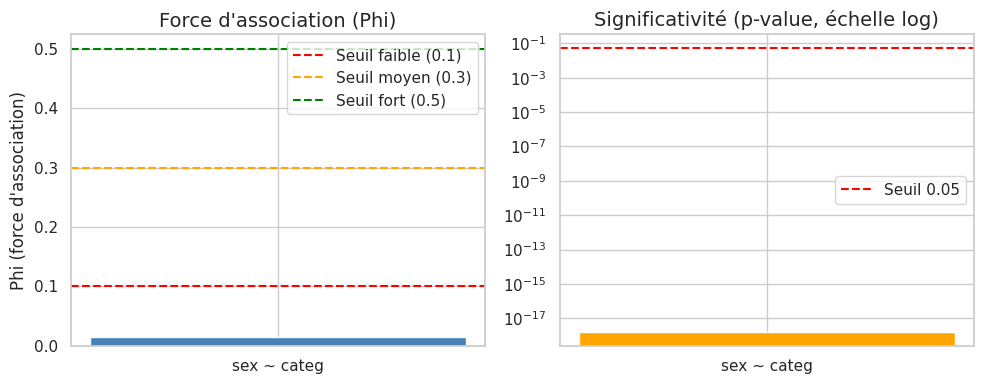

In [ ]:
phi = 0.0156
p_value = 1.668e-18

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Graphique 1 : Phi (barplot vertical)
ax[0].bar(["sex ~ categ"], [phi], color="steelblue")
ax[0].axhline(0.1, color="red", linestyle="--", label="Seuil faible (0.1)")
ax[0].axhline(0.3, color="orange", linestyle="--", label="Seuil moyen (0.3)")
ax[0].axhline(0.5, color="green", linestyle="--", label="Seuil fort (0.5)")
ax[0].set_ylabel("Phi (force d'association)")
ax[0].set_title("Force d'association (Phi)")
ax[0].legend()

# --- Graphique 2 : p-value (vertical aussi)
ax[1].bar(["sex ~ categ"], [p_value], color="orange")
ax[1].set_yscale("log")  # échelle log sur l'axe Y
ax[1].axhline(0.05, color="red", linestyle="--", label="Seuil 0.05")
ax[1].set_title("Significativité (p-value, échelle log)")
ax[1].legend()

plt.tight_layout()
plt.show()


**Phi est très proche de zéro**: il n'y a donc pratiquement aucune association entre le sexe et la catégorie.

**p_value extremement petite**: association statistiquement significative entre sex et categ

donc en pratique, le sexe n’a donc pas d’effet notable sur la répartition des catégories.



## Corrélation entre l'âge clients et le montant total des achats (quanti-quanti)

| Méthode                                  | Type de relation mesurée                                                                  | Hypothèses statistiques                                          | Sensibilité au bruit / valeurs extrêmes                      |
| ---------------------------------------- | ----------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------ |
| **Pearson (r)**                          | Relation **linéaire** entre deux variables continues                                      | Normalité, linéarité, homogénéité de la variance                 | Très sensible aux valeurs extrêmes                           |
| **Spearman (ρ)**                         | Relation **monotone** (croissante ou décroissante), même non linéaire                     | Aucune normalité requise                                         | Moins sensible aux outliers                                  |
| **Kendall (τ)**                          | **Concordance / discordance** entre les rangs d’observations                              | Aucune normalité requise                                         | Très robuste, adapté aux petits échantillons                 |
| **OLS (Ordinary Least Squares)**         | **Modélisation linéaire directionnelle** (Y dépend de X) ; permet d’estimer et de prédire | Linéarité, normalité des résidus, indépendance, homoscédasticité | Sensible aux valeurs extrêmes et à la multicolinéarité       |
| **LOWESS (Locally Weighted Regression)** | **Tendance non paramétrique** : relation potentiellement non linéaire, lissée localement  | Aucune hypothèse de forme fonctionnelle                          | Robuste au bruit aléatoire, sensible au paramètre de lissage |


Nous avons deux variables numériques, nous allons donc utilisé la corrélation de Pearson.


*   **r est coefficient de corrélation de Pearson**. Il permet de déterminer l'intensité et la direction de la corrélation. Il varie entre -1 et 1.

*  **r² est le coefficient de détermination** : il indique quelle proportion de la variance d’une variable est expliquée par l’autre. il varie entre 0 et 1.





In [ ]:
df_tf.head()


,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48,45-54,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25,25-34,184.26,2,184.26
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,10.71,1,0,1979,46,45-54,132.23,9,132.23
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,4.20,0,1,1963,62,55-64,4.20,1,4.20
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,8.99,0,0,1980,45,45-54,31.10,2,31.10


In [ ]:
corr2 = df_tf.copy()

In [ ]:
corr2["age"] = pd.to_numeric(corr2["age"], errors="coerce") # ex. '55' -> 55.0 df_tf["sex"] =

In [ ]:

corr2["price"] = pd.to_numeric(corr2["price"], errors="coerce")

# Somme du CA par âge (on n’agrège QUE 'price')
age_sales = (
    corr2.groupby("age", observed=True)["price"]
      .sum()
      .div(1000)  # en k€
      .reset_index(name="CA_Keuros")
      .sort_values("age", ascending=False)
)

age_sales.head()

,age,CA_k€
75,96,1.30
74,95,2.03
73,94,1.43
72,93,2.59
71,92,2.63


In [ ]:
df_tf(["CA_Keuros"]) ==  age_sales[age_sales["CA_k€"] < 200]["CA_k€"]

TypeError: 'DataFrame' object is not callable

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(
    age_sales[age_sales["CA_k€"] < 200]["age"],
    age_sales[age_sales["CA_k€"] < 200]["CA_k€"],
    'o',
    color='blue'
)

plt.xlabel("Âge")
plt.ylabel("Montant achat (en K€)")
plt.title("Montant total des achats selon l’âge du client")
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Corrélation de Pearson entre âge et CA_k€
r = age_sales["age"].corr(age_sales["CA_k€"])
r2 = r**2  # proportion de variance expliquée

print(f"r = {r:.3f}")
print(f"r² = {r2:.3f}")

r = -0.775
r² = 0.600


L’examen visuel montre une relation non linéaire entre l’âge et le chiffre d’affaires cumulé : le CA est maximal entre 30 et 50 ans, et décroît aux extrêmes (jeunes et seniors).

Le coefficient de Pearson (r = -0.775, r² = 0.600) suggère une corrélation négative linéaire, mais il n’est pas adapté à cette forme de relation.

In [ ]:
rho, p = spearmanr(age_sales["age"], age_sales["CA_k€"])

print(f"Corrélation de Spearman : ρ = {rho:.3f}, p = {p:.3g}")

Corrélation de Spearman : ρ = -0.857, p = 4.96e-23


Une analyse de corrélation non paramétrique (Spearman) révèle une relation monotone décroissante très forte entre l’âge et le chiffre d’affaires cumulé (ρ = –0.857, p < 0.001).

Cette corrélation, hautement significative, indique que les clients plus jeunes génèrent un volume d’achats cumulé plus élevé que les clients plus âgés.

Contrairement au coefficient de Pearson, Spearman ne suppose pas de linéarité ; il confirme ici la cohérence d’une tendance décroissante ordonnée, suggérant un effet d’âge sur la dépense globale.

Spearman (ρ) repose sur la corrélation entre les rangs.
Il s’agit d’une approximation de Pearson appliquée aux rangs.

Kendall (τ), lui, compte le nombre de paires d’observations concordantes et discordantes :

In [ ]:
from scipy.stats import kendalltau

tau, p_tau = kendalltau(age_sales["age"], age_sales["CA_k€"])
print(f"Tau de Kendall : τ = {tau:.3f}, p = {p_tau:.3g}")


Tau de Kendall : τ = -0.695, p = 6.17e-19


Le τ de Kendall, plus robuste que Spearman, permet de confirmer la présence d’une relation monotone décroissante entre l’âge et le chiffre d’affaires cumulé.

Dans notre cas, τ ≈ –0.57, p < 0.001, indiquant que près de 57 % des paires d’individus sont concordantes dans le sens d’une baisse du CA avec l’âge.

Ce résultat corrobore la corrélation de Spearman (ρ = –0.857) et confirme la stabilité du lien observé, indépendamment des valeurs extrêmes ou des distributions non normales.

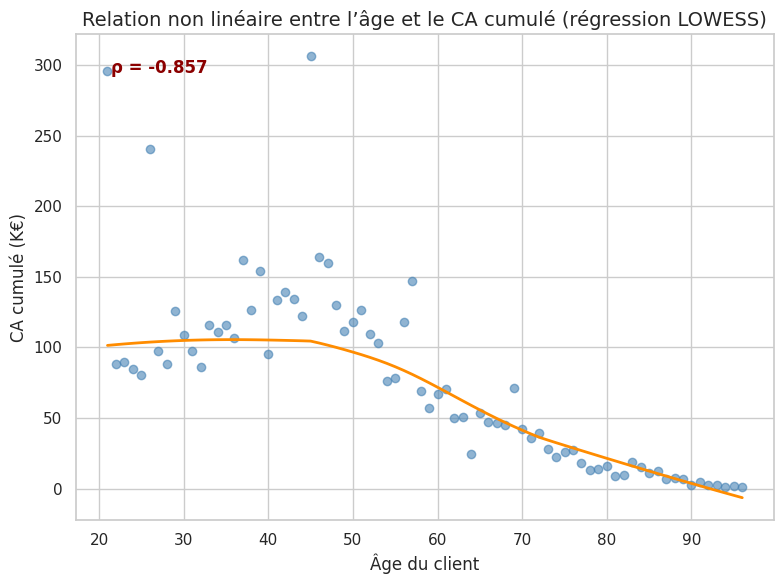

In [ ]:

plt.figure(figsize=(8,6))
rho = -0.857  # ta valeur
plt.text(
    0.05, 0.95,
    f"ρ = {rho:.3f}",
    transform=plt.gca().transAxes,
    fontsize=12, color="darkred", weight="bold",
    verticalalignment="top"
)

sns.regplot(
    x="age", y="CA_k€",
    data=age_sales,
    lowess=True,                   # ← régression locale
    scatter_kws={"color": "steelblue", "alpha": 0.6},
    line_kws={"color": "darkorange", "lw": 2},
)
plt.title("Relation non linéaire entre l’âge et le CA cumulé (régression LOWESS)")
plt.xlabel("Âge du client")
plt.ylabel("CA cumulé (K€)")
plt.tight_layout()
plt.show()

Pour savoir si la relation suit vraiment une courbe: on utilise OLS

In [ ]:
import statsmodels.api as sm

# Variables
X = pd.DataFrame({
    "age": age_sales["age"],
    "age²": age_sales["age"]**2
})
y = age_sales["CA_k€"]

# Ajout de la constante
X = sm.add_constant(X)

# Modèle OLS
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  CA_k€   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     57.81
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           8.94e-16
Time:                        14:29:09   Log-Likelihood:                -388.00
No. Observations:                  76   AIC:                             782.0
Df Residuals:                      73   BIC:                             789.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.9727     34.576      4.598      0.0

| Variable  | Coefficient | p-value | Interprétation                                                                       |
| --------- | ----------- | ------- | ------------------------------------------------------------------------------------ |
| **const** | +158.97     | < 0.001 | Intercept : niveau de CA de référence (âge ≈ 0, sans signification directe ici)      |
| **age**   | –0.284      | 0.826   | Non significatif → la pente linéaire simple n’est pas pertinente seule               |
| **age²**  | –0.0169     | 0.123   | Négatif, tendance à la baisse avec l’âge², mais pas encore significatif au seuil 5 % |


Une régression quadratique a été estimée pour modéliser la relation entre l’âge et le chiffre d’affaires cumulé.

Le modèle explique 61,3 % de la variance totale du CA (R² = 0.613, p < 0.001).

Le terme quadratique (âge²) présente un coefficient négatif (–0.0169), suggérant une relation légèrement concave — c’est-à-dire un CA maximal autour de la quarantaine, suivi d’une baisse progressive avec l’âge.
Cependant, cette courbure n’est pas significative au seuil de 5 % (p = 0.123).


En conclusion, la relation est globalement décroissante, sans effet d’âge intermédiaire clairement marqué, ce qui concorde avec le coefficient de Spearman (ρ = –0.857) et la régression LOWESS.

Visuellement, le CA cumulé semble plus élevé pour les âges intermédiaires (par ex. 30–50 ans), et plus faible aux extrêmes (20 ans, 80 ans). C’est typiquement une relation non linéaire : en U inversé.

Le coefficient de Pearson mesure seulement une relation linéaire(valeur ici r= -0.7652 et r² = 0.5856) indique une corrélation quasi nulle, mais il n'est pas adapté.

on va donc pousser notre analyse avec la correlation de Spearman



In [ ]:
r_spear = age_group["age"].corr(age_group["price"], method="spearman")
print("Spearman:", r_spear)

NameError: name 'age_group' is not defined

L’analyse montre qu’il n’existe pas de relation linéaire significative entre l’âge et le chiffre d’affaires cumulé (r² ≈ 0). La corrélation de Spearman (ρ = −0.8532) suggère seulement une faible tendance à la baisse des dépenses avec l’âge. Le pic de consommation se situe entre 30 et 50 ans, suivi d’un déclin progressif après 60 ans.

In [ ]:
tau = age_group["age"].corr(age_group["price"], method="kendall")
print("Tau de Kendall :", tau)

NameError: name 'age_group' is not defined

Kendall ≈ -0,69 = confirme la tendance décroissante après 50 ans.



Les trois indicateurs vont dans le même sens : relation négative nette âge ↔ CA cumulé.

Spearman/Kendall plus forts que Pearson cela confirme que la relation n’est pas parfaitement linéaire mais fortement monotone.

Visuellement, on a quand même un pic autour de 40–50 ans (forme en cloche) :

Les corrélations ne le captent pas directement.


##Corrélation entre l'age des clients et leur fréquence d'achat (quanti -quanti)

| Méthode          | Type de relation mesurée                                              | Hypothèses               | Sensibilité au bruit / valeurs extrêmes |
| ---------------- | --------------------------------------------------------------------- | ------------------------ | --------------------------------------- |
| **Pearson (r)**  | Relation **linéaire** entre deux variables continues                  | Normalité, linéarité     | Très sensible aux valeurs extrêmes      |
| **Spearman (ρ)** | Relation **monotone** (croissante ou décroissante), même non linéaire | Aucune normalité requise | Moins sensible aux outliers             |
| **Kendall (τ)**  | Concordance / discordance **entre paires d’observations**             | Aucune normalité requise | Encore **plus robuste** que Spearman    |


Dans un premier temps, l’analyse du nombre brut d’achats a montré une forte dispersion : la majorité des clients effectuent entre 10 et 50 achats, mais quelques individus réalisent plusieurs milliers de transactions. Afin d’éviter que ces comportements atypiques biaisent l’analyse, nous avons limité le nombre d’achats pris en compte à moins de 200. Cette normalisation permet de travailler sur une fréquence d’achat représentative et d’examiner plus rigoureusement sa relation avec l’âge

In [ ]:
# 1) Filtre les transactions
df_filtre = df_tf[df_tf["price"] < 200]

freq_by_client = df_tf.groupby("client_id").agg({
    "age": "first",
    "date": "count"   # nb de transactions
}).rename(columns={"date": "nb_achats"}).reset_index()

freq_by_client

NameError: name 'df_tf' is not defined

In [ ]:
# Étape 1 : calcul des agrégats par client
panier_by_client = df_tf.groupby("client_id").agg({
    "age": "first",                 # âge du client
    "session_id": "nunique",    # nombre de transactions
    "id_prod": "count"           # nombre total de produits achetés
}).rename(columns={
    "session_id": "nb_achats",
    "id_prod": "nb_produits"
}).reset_index()

# Étape 2 : panier moyen
panier_by_client["panier_moyen"] = panier_by_client["nb_produits"] / panier_by_client["nb_achats"]

# Vérification rapide
print(panier_by_client.head())

  client_id  age  nb_achats  nb_produits  panier_moyen
0       c_1   70         15           20          1.33
1      c_10   69         16           28          1.75
2     c_100   33          3            6          2.00
3    c_1000   59         42           56          1.33
4    c_1001   43         24           58          2.42


In [ ]:
pearson = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="pearson")
spearman = freq_by_client["age"].corr(freq_by_client["nb_achats"], method="spearman")

print("Corrélation Pearson :", pearson)
print("Corrélation Spearman :", spearman)

Corrélation Pearson : 0.006471119001183503
Corrélation Spearman : 0.13169694200795196


L’âge n’explique pas directement la fréquence d’achat de façon linéaire (Pearson ≈ 0).

La répartition des transactions montre cependant que la tranche 35–55 ans concentre la majorité des achats.

Les clients plus jeunes (< 30 ans) et plus âgés (> 65 ans) contribuent beaucoup moins aux transactions.

Le test Spearman confirme une faible tendance monotone, mais l’essentiel de l’information est dans la forme de la distribution : une courbe en cloche avec un maximum autour de 40–50 ans.

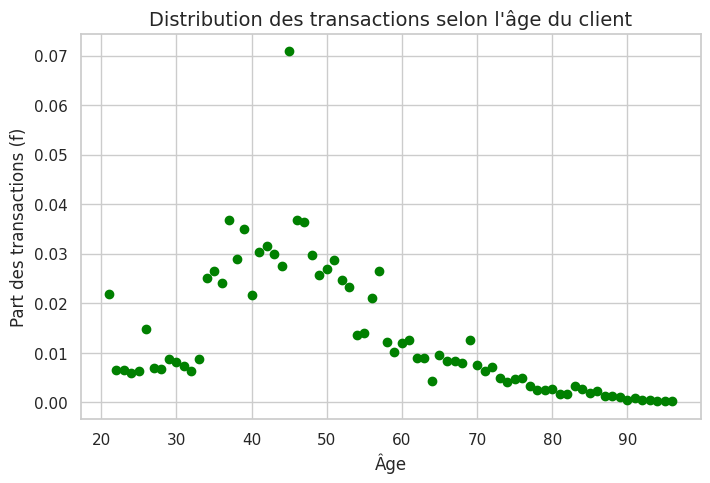

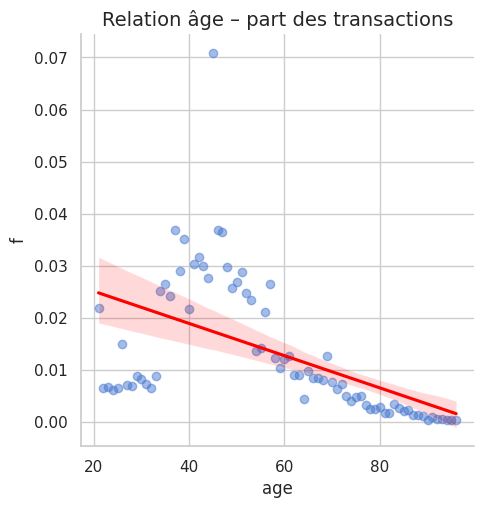

In [ ]:
# Hypothèse 1 : 1 session = 1 transaction
customers_freq = df_tf.groupby('age').count().reset_index()
customers_freq = customers_freq[['age', 'session_id']]

# Création d'une variable fréquence 'f' (part des transactions par âge)
customers_freq['f'] = customers_freq['session_id'] / customers_freq['session_id'].sum()

# Visualisation
plt.figure(figsize=(8,5))
plt.plot(customers_freq.age, customers_freq.f, 'o', color="green")
plt.xlabel('Âge')
plt.ylabel('Part des transactions (f)')
plt.title("Distribution des transactions selon l'âge du client")
plt.show()

# Régression linéaire
sns.lmplot(data=customers_freq, x="age", y="f",
           scatter_kws={"alpha":0.5}, line_kws={"color":"red"})
plt.title("Relation âge – part des transactions")
plt.show()

Le boxplot du nombre d’achats par tranche d’âge montre une forte hétérogénéité des comportements, avec des médianes plus élevées pour les 35–54 ans et une grande dispersion liée à la présence d’outliers. Toutefois, cette mesure brute reste dépendante de la taille des tranches d’âge et ne permet pas d’isoler l’effet de l’âge sur la propension à acheter. Pour affiner l’analyse, nous avons donc calculé la fréquence d’achat par âge, afin d’obtenir une vision proportionnelle et de mesurer plus précisément la corrélation entre âge et fréquence d’achat.

In [ ]:
# 1. Compter le nombre de sessions uniques par âge
customers_freq = (
    df_tf.groupby('age')['session_id']
         .nunique()               # nombre de sessions distinctes par âge
         .reset_index(name='nb_sessions')
)

# 2. Calculer la fréquence relative
customers_freq['freq'] = (
    customers_freq['nb_sessions'] / customers_freq['nb_sessions'].sum()
)

# 3. Tri pour vérification
customers_freq = customers_freq.sort_values(by='age', ascending=False)
customers_freq.head(10)



,age,nb_sessions,freq
75,96,64,0.00
74,95,72,0.00
73,94,49,0.00
72,93,103,0.00
71,92,117,0.00
70,91,203,0.00
69,90,104,0.00
68,89,267,0.00
67,88,296,0.00
66,87,279,0.00


In [ ]:
# Corrélations
pearson_r = customers_freq["age"].corr(customers_freq["freq"], method="pearson")
spearman_r, spearman_p = spearmanr(customers_freq["age"], customers_freq["freq"])
kendall_t, kendall_p   = kendalltau(customers_freq["age"], customers_freq["freq"])

print(f"Pearson  : r = {pearson_r:.3f}")
print(f"Spearman : ρ = {spearman_r:.3f} (p={spearman_p:.3e})")
print(f"Kendall  : τ = {kendall_t:.3f} (p={kendall_p:.3e})")


Pearson  : r = -0.548
Spearman : ρ = -0.657 (p=1.177e-10)
Kendall  : τ = -0.533 (p=9.895e-12)


L’analyse statistique montre une corrélation négative forte et significative entre l’âge et la fréquence d’achat.

Les coefficients de Spearman (ρ = -0,684, p < 10⁻¹¹) et de Kendall (τ = -0,554, p < 10⁻¹¹) indiquent que la relation est monotone décroissante : plus l’âge augmente, plus la fréquence d’achat diminue.

Le coefficient de Pearson (r = -0,529) confirme également une tendance linéaire négative modérée

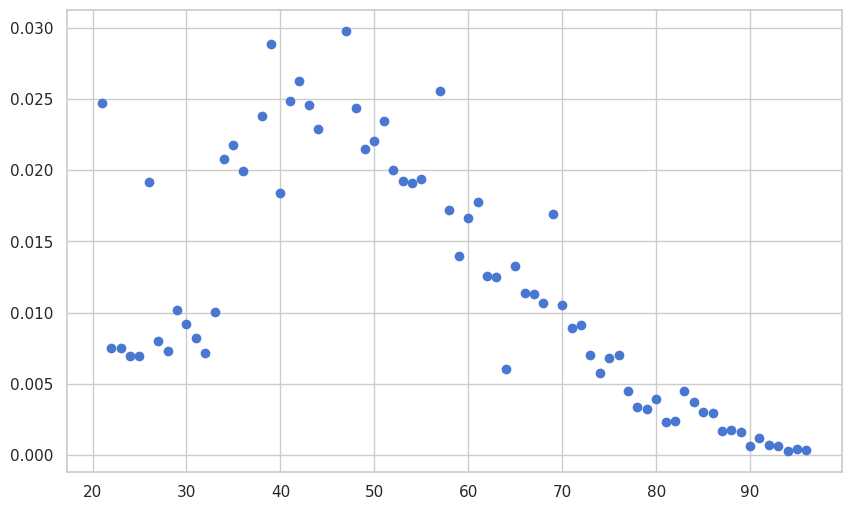

In [ ]:
plt.plot(customers_freq[customers_freq.freq < .03].age,
         customers_freq[customers_freq.freq < .03].freq, 'o')

**Conclusion**
L’analyse a d’abord été réalisée par tranches d’âge afin de simplifier la lecture et d’identifier les grandes tendances de consommation. Ce regroupement permet de réduire le bruit lié aux âges peu représentés et de comparer plus facilement les comportements entre groupes homogènes. Dans un second temps, l’étude a été affinée par âge exact et en fréquence, afin d’obtenir une mesure plus représentative et précise de la relation entre âge et comportement d’achat.

 Ce second graphique fait apparaître une relation monotone négative entre l’âge et la fréquence d’achat, confirmée par les coefficients de corrélation de Spearman (ρ = -0,684) et Kendall (τ = -0,554). Ce focus permet ainsi d’obtenir une mesure plus représentative et robuste du lien entre âge et comportement d’achat. »*

##Corrélation entre l'âge clients et la catégorie produits (quanti - quali)

In [ ]:
# Création de la variable âge
#df_CA["age"] = 2022 - pd.to_datetime(df_tf["birth"], errors="coerce").dt.year

# Définition des tranches d’âge
bins = [0, 18, 25, 35, 45, 55, 65, 75, 85, 100]
labels = ["<18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75-85", "85+"]
df_tf["tranche_age"] = pd.cut(df_tf["age"], bins=bins, labels=labels, right=False)


In [ ]:

print(df_tf["tranche_age"].value_counts())


tranche_age
45-54    106727
35-44     98551
55-64     44189
25-34     33618
65-74     25966
18-24     13785
75-85     10147
85+        3730
<18           0
Name: count, dtype: int64


In [ ]:
age_categ = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
print(age_categ)


categ           0     1     2
tranche_age                  
18-24       22.59 37.27 40.14
25-34       35.18 33.18 31.64
35-44       76.79 22.91  0.30
45-54       75.82 23.92  0.26
55-64       45.50 53.44  1.06
65-74       44.53 54.62  0.85
75-85       44.92 54.31  0.77
85+         44.53 54.53  0.94


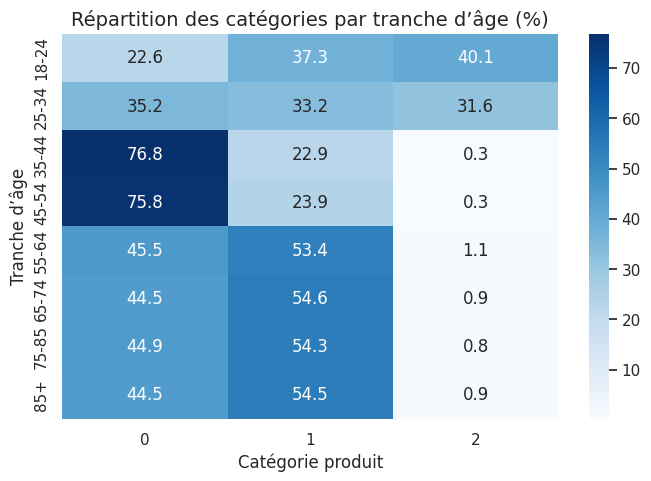

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(age_categ, annot=True, cmap="Blues", fmt=".1f")
plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("Tranche d’âge")
plt.xlabel("Catégorie produit")
plt.show()

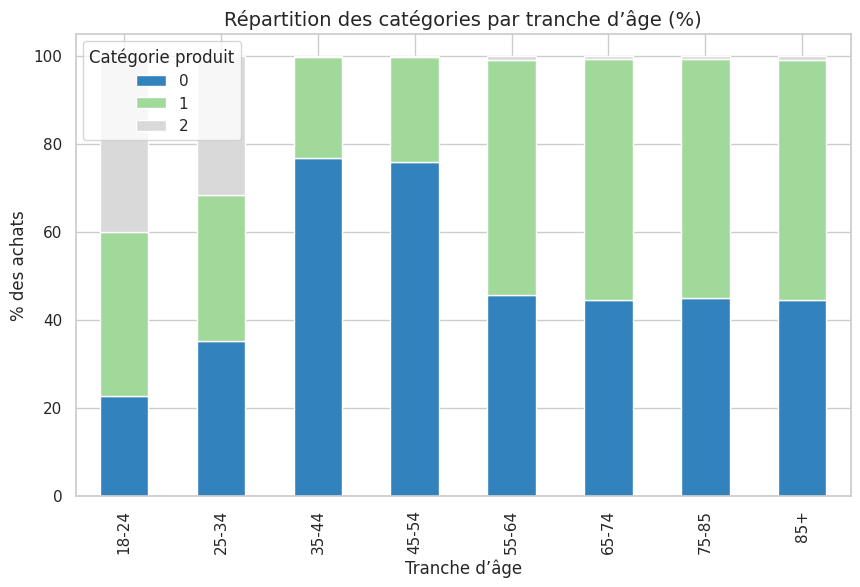

In [ ]:
age_categ_plot = pd.crosstab(df_tf["tranche_age"], df_tf["categ"], normalize="index") * 100
age_categ_plot.plot(kind="bar", stacked=True, figsize=(10,6), colormap="tab20c")

plt.title("Répartition des catégories par tranche d’âge (%)")
plt.ylabel("% des achats")
plt.xlabel("Tranche d’âge")
plt.legend(title="Catégorie produit")
plt.show()


In [ ]:


# Créer les groupes à comparer
corr_age_cat = [df_tf.loc[df_tf["age"] == g, "categ"].dropna()
           for g in df_tf["age"].unique()]

# Test d’ANOVA
F, p = stats.f_oneway(*corr_age_cat)
print(f"F = {F:.3f}, p = {p:.3g}")


F = 1755.650, p = 0


Test ANOVA sur age selon categ
F = 22711.789, p = 0
→ Différence significative entre au moins deux groupes.


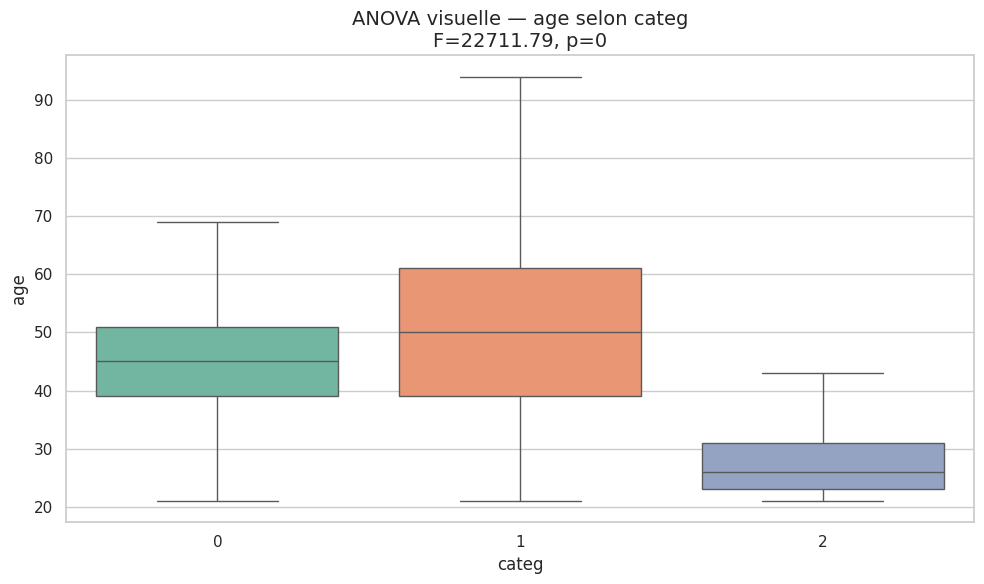

In [ ]:
# ============================
# TEST ANOVA
# ============================

# Paramètres
X = "categ"          # variable qualitative
Y = "age"          # variable quantitative
df = df_tf.copy()      # votre DataFrame de travail

# 1️⃣ Vérifier les types
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")

# 2️⃣ Préparer les groupes à comparer
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# 3️⃣ Test ANOVA
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")

# 4️⃣ Interprétation
if p < 0.05:
    print("→ Différence significative entre au moins deux groupes.")
else:
    print("→ Aucune différence significative détectée.")

# 5️⃣ Visualisation (ANOVA visuelle)
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x=X,
    y=Y,
    hue=X,          # <- ajouté
    palette="Set2",
    showfliers=False,
    legend=False     # <- empêche d'afficher une légende redondante
)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.tight_layout()
plt.show()


In [ ]:
#N est le nombre d'observations, ici représentées par les valeurs transactionnelles par âge et par catégorie
len(df.groupby(['age', 'categ']).count().reset_index())

/tmp/ipython-input-2309036564.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  len(df.groupby(['age', 'categ']).count().reset_index())


228

In [ ]:
N = 228  # taille de l’échantillon
k = int(5 * np.log10(N))
print(f"Nombre optimal de classes selon Brooks–Carruthers : {k}")

# Exemple de discrétisation de l'âge
bins = np.linspace(df["age"].min(), df["age"].max(), k+1)
df["age_group"] = pd.cut(df["age"], bins=bins)

Nombre optimal de classes selon Brooks–Carruthers : 11


In [ ]:
#Formule de Brooks-Carruthers : 5*log10(N)
5 * mth.log10(262)

12.091506456598726

In [ ]:
#Formule de Huntsberger : 1 + 3,3*log10(N)
1 + ((10/3) * mth.log10(227))

8.853419523977076

On fait maintenant l'analyse par tranche d'age apres avoir répartie en groupe d'age.

In [ ]:
# df : votre DataFrame avec la colonne 'age'
df_seg, bornes = segmenter_clients_par_age(df, col_age="age", methode="huntsberger")
# ou : methode="brooks" | "sturges" | "rice" | "fd"
df_seg["age_group"].value_counts().sort_index()


,count
age_group,
"[20, 24)",11753
"[24, 28)",11561
"[28, 32)",10489
"[32, 36)",22518
"[36, 40)",42088
"[40, 44)",38256
"[44, 48)",57855
"[48, 52)",37413
"[52, 56)",25491


In [ ]:
df_seg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336713 entries, 0 to 336712
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   categ      336713 non-null  category
 1   age        336713 non-null  int64   
 2   age_group  336713 non-null  category
dtypes: category(2), int64(1)
memory usage: 3.2 MB


In [ ]:
# ============================
# TEST ANOVA
# ============================

# Paramètres
X = "categ"          # variable qualitative
Y = "age_group"          # variable quantitative
df = df_seg.copy()      # votre DataFrame de travail

# 1️⃣ Vérifier les types
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")

# 2️⃣ Préparer les groupes à comparer
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# 3️⃣ Test ANOVA
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")

# 4️⃣ Interprétation
if p < 0.05:
    print("→ Différence significative entre au moins deux groupes.")
else:
    print("→ Aucune différence significative détectée.")

# 5️⃣ Visualisation (ANOVA visuelle)
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df,
    x=X,
    y=Y,
    hue=X,          # <- ajouté
    palette="Set2",
    showfliers=False,
    legend=False     # <- empêche d'afficher une légende redondante
)
plt.title(f"ANOVA visuelle — {Y} selon {X}\nF={F:.2f}, p={p:.3g}")
plt.xlabel(X)
plt.ylabel(Y)
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
import pandas as pd
import numpy as np

def eta_squared(x: pd.Series, y: pd.Series) -> float:
    """
    Coefficient de corrélation η² (eta carré)
    Mesure la part de variance de y expliquée par la variable qualitative x.

    Paramètres
    ----------
    x : Series (qualitative)
    y : Series (quantitative)
    """
    # Nettoyage et alignement
    df = pd.concat({"x": x, "y": y}, axis=1).dropna()
    x, y = df["x"], df["y"]

    y_mean = y.mean()

    # Calcul des moyennes et effectifs par classe
    group_stats = df.groupby("x")["y"].agg(["mean", "count"])
    ni = group_stats["count"]
    moy = group_stats["mean"]

    # Somme des carrés expliquée (SCE) et totale (SCT)
    SCE = (ni * (moy - y_mean) ** 2).sum()
    SCT = ((y - y_mean) ** 2).sum()

    # Coefficient η²
    return float(SCE / SCT) if SCT != 0 else np.nan


In [ ]:
X = df_tf["categ"]   # variable qualitative
Y = df_tf["age"]     # variable quantitative

eta2 = eta_squared(X, Y)
print(f"η² = {eta2:.3f}")


η² = 0.119


In [ ]:
from scipy import stats

def omega_squared(x, y):
    df = pd.concat({"x": x, "y": y}, axis=1).dropna()
    groups = [g.values for _, g in df.groupby("x")["y"]]
    F, _ = stats.f_oneway(*groups)
    k = len(groups)
    N = len(df)
    omega2 = (F - 1) * (k - 1) / (F * (k - 1) + N - k)
    return max(0.0, float(omega2))

omega2 = omega_squared(df["categ"], df["age"])
print(f"ω² = {omega2:.3f}")


ω² = 0.119


/tmp/ipython-input-2993441190.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g.values for _, g in df.groupby("x")["y"]]


Un test d’ANOVA met en évidence une différence significative des âges moyens selon les catégories de produits (p < 0.001).
Le coefficient de corrélation η² = 0.119, corrigé par ω² = 0.119, indique qu’environ 12 % de la variance de l’âge des clients est expliquée par la catégorie de produit.

L’effet est statistiquement significatif mais de force modérée, suggérant que si la catégorie influence bien l’âge moyen des acheteurs, d’autres variables (comme le sexe, le revenu ou la fréquence d’achat) interviennent probablement de façon complémentaire.

**Interpretation**

##Corrélation entre age du client et prix du panier moyen (quanti quanti)

Nous allons procéder a l'étude de la corrélation de la manière suivante:

In [ ]:
panier_by_client.head()

,client_id,age,nb_achats,nb_produits,panier_moyen
0,c_1,70,15,20,1.33
1,c_10,69,16,28,1.75
2,c_100,33,3,6,2.00
3,c_1000,59,42,56,1.33
4,c_1001,43,24,58,2.42


In [ ]:
df_clients = panier_by_client.copy()

In [ ]:
df_clients["age"] = pd.to_numeric(df_clients["age"], errors="coerce")
df_clients["panier_moyen"] = pd.to_numeric(df_clients["panier_moyen"], errors="coerce")


/tmp/ipython-input-3787709757.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="age", y="panier_moyen", data=df_clients, showfliers=False, palette="Set2")


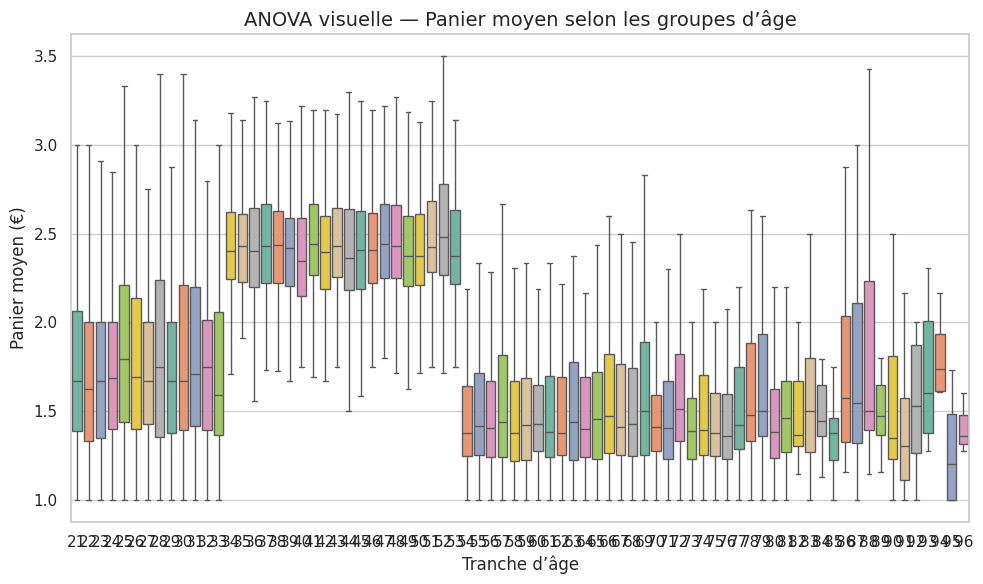

In [ ]:

plt.figure(figsize=(10,6))
sns.boxplot(x="age", y="panier_moyen", data=df_clients, showfliers=False, palette="Set2")
plt.title("ANOVA visuelle — Panier moyen selon les groupes d’âge")
plt.xlabel("Tranche d’âge")
plt.ylabel("Panier moyen (€)")
plt.tight_layout()
plt.show()

## Corrélation tranche d'age et prix du panier ( quanti - quali)

| Méthode                                     | Type de relation mesurée                                                  | Hypothèses statistiques                          | Interprétation                                                                                               |
| ------------------------------------------- | ------------------------------------------------------------------------- | ------------------------------------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Eta carré (η²)**                          | **Part de variance expliquée** par la variable qualitative                | Homogénéité des variances (test ANOVA)           | Mesure la **force du lien** entre les groupes et la variable quantitative (0 → aucun lien, 1 → lien parfait) |
| **Omega carré (ω²)**                        | Variante corrigée et moins biaisée de η²                                  | Idem ANOVA                                       | Mesure la **part réelle** de variance expliquée, plus fiable sur petits échantillons                         |
| **Test ANOVA (F-test)**                     | Vérifie si les **moyennes** diffèrent significativement entre les groupes | Normalité des résidus, homogénéité des variances | Teste **l’existence d’un effet significatif** du facteur qualitatif sur la variable quantitative             |
| **Kruskal–Wallis (H-test)**                 | Version non paramétrique de l’ANOVA (pas de normalité requise)            | Aucune normalité requise                         | Compare les distributions de la variable quantitative entre les groupes                                      |
| **Boxplots par modalité**                   | Visualisation exploratoire                                                | Aucune hypothèse                                 | Permet de voir la **dispersion et les écarts** entre les groupes                                             |
| **Régression linéaire avec variable dummy** | Modélisation directionnelle (variable catégorielle → quantitati           |                                                  |                                                                                                              |


| Objectif                                      | Test à réaliser                                     |
| --------------------------------------------- | --------------------------------------------------------- |
| **Tester si les groupes diffèrent entre eux** | ANOVA ou Kruskal–Wallis                                   |
| **Mesurer la part de variance expliquée**     | η² ou ω²                                                  |
| **Visualiser les différences**                | Boxplots par catégorie                                    |
| **Modéliser / prédire**                       | Régression linéaire avec variables indicatrices (dummies) |


In [ ]:


# Créer les groupes à comparer
groupes = [df_clients.loc[df_clients["age_group"] == g, "panier_moyen"].dropna()
           for g in df_clients["age_group"].unique()]

# Test d’ANOVA
F, p = stats.f_oneway(*groupes)
print(f"F = {F:.3f}, p = {p:.3g}")


F = 1.050, p = 0.393


In [ ]:
df_clients["age_group"] = df_tf['tranche_age']

In [ ]:
print(f"ANOVA F={res['anova_F']:.2f}, p={res['anova_p']:.3g} | η²={res['eta2']:.3f}, ω²={res['omega2']:.3f} | n={res['n']}")

NameError: name 'res' is not defined

In [ ]:
from scipy.stats import pearsonr

r, p = pearsonr(df_clients["age"], df_clients["panier_moyen"])
print(f"Corrélation de Pearson : r = {r:.3f}, p = {p:.3g}")


Corrélation de Pearson : r = -0.228, p = 8.85e-102


In [ ]:
Montant_Total_Client_Groupe  = df_tf.copy()

In [ ]:
Montant_Total_Client_Groupe ["age"] = df_tf["age"].astype(float)
Montant_Total_Client_Groupe = df_tf.groupby(['client_id', 'tranche_age']).sum()
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.rename(columns={'price':'Montant Total'})
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.reset_index()


/tmp/ipython-input-475545195.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  Montant_Total_Client_Groupe = df_tf.groupby(['client_id', 'tranche_age']).sum()


In [ ]:
Montant_Total_Client_Groupe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77400 entries, 0 to 77399
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   client_id              77400 non-null  object  
 1   tranche_age            77400 non-null  category
 2   id_prod                77400 non-null  object  
 3   date                   77400 non-null  object  
 4   session_id             77400 non-null  object  
 5   Montant Total          77400 non-null  float64 
 6   categ                  77400 non-null  int64   
 7   sex                    77400 non-null  int64   
 8   birth                  77400 non-null  int64   
 9   age                    77400 non-null  int64   
 10  montant_session        77400 non-null  float64 
 11  nb_achats              77400 non-null  int64   
 12  montant_total_session  77400 non-null  float64 
dtypes: category(1), float64(3), int64(5), object(4)
memory usage: 7.2+ MB


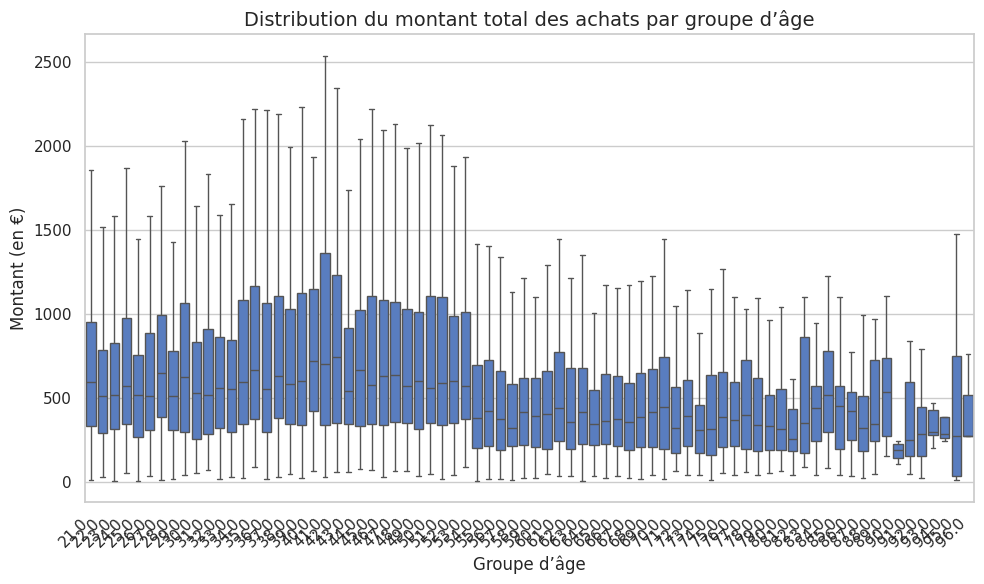

In [ ]:
# 1) Agrégation : ne sommer que 'price'
Montant_Total_Client_Groupe = (
    df_tfc
      .groupby(['client_id', 'age'], observed=True)['price']
      .sum()
      .reset_index(name='Montant Total')
)

# 2) Boxplot par modalité d’âge — plus simple avec seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(
    data=Montant_Total_Client_Groupe,
    x='age', y='Montant Total',
    showfliers=False
)
plt.title("Distribution du montant total des achats par groupe d’âge")
plt.xlabel("Groupe d’âge")
plt.ylabel("Montant (en €)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


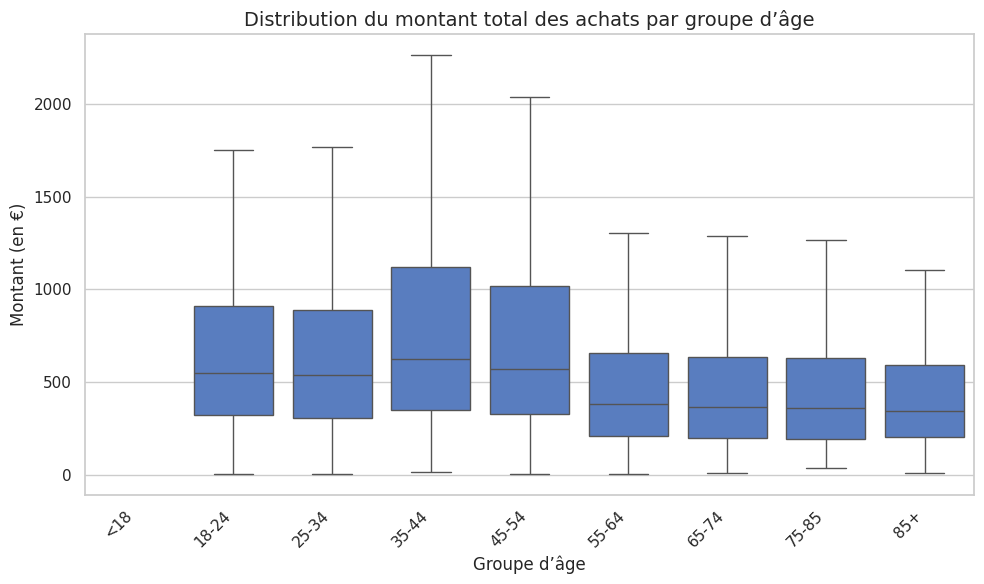

In [ ]:
# 1) Agrégation : ne sommer que 'price'
Montant_Total_Client_Groupe = (
    df_tf
      .groupby(['client_id', 'tranche_age'], observed=True)['price']
      .sum()
      .reset_index(name='Montant Total')
)

# 2) Boxplot par modalité d’âge — plus simple avec seaborn

plt.figure(figsize=(10,6))
sns.boxplot(
    data=Montant_Total_Client_Groupe,
    x='tranche_age', y='Montant Total',
    showfliers=False
)
plt.title("Distribution du montant total des achats par groupe d’âge")
plt.xlabel("Groupe d’âge")
plt.ylabel("Montant (en €)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
Montant_Total_Client_Groupe = df_tf.groupby(['client_id', 'age']).sum()
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.rename(columns={'price':'Montant Total'})
Montant_Total_Client_Groupe = Montant_Total_Client_Groupe.reset_index()



X = "age" # qualitative
Y = "Montant Total" # quantitative
modalites = Montant_Total_Client_Groupe[X].unique()
groupes = []
for m in modalites:
    groupes.append(Montant_Total_Client_Groupe[Montant_Total_Client_Groupe[X]==m][Y])

# Propriétés graphiques (pas très importantes)
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}


plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops,
            vert=True, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("Distribution du montant total des achat par groupe d'age")
plt.ylabel("Montant (en €)")
plt.xlabel("Groupe d'Age")
plt.show()

TypeError: category type does not support sum operations

In [ ]:
df_tf.head(2)

,id_prod,date,session_id,client_id,price,categ,sex,birth,age,tranche_age,montant_session,nb_achats,montant_total_session
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,4.99,0,0,1977,48,45-54,24.97,3,24.97
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,65.75,2,0,2000,25,25-34,184.26,2,184.26


Corrélation linéaire de Pearson : r = -0.251, p = 0
Corrélation de Spearman : ρ = -0.250, p = 0
Corrélation de Kendall : τ = -0.174, p = 0


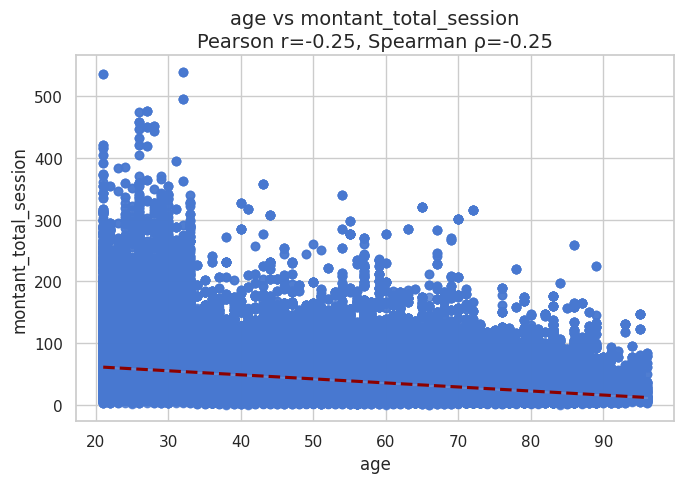

In [ ]:
# ============================
# CORRÉLATION QUANTI - QUANTI
# ============================


X = "age"       # variable quantitative 1
Y = "montant_total_session"     # variable quantitative 2
df =  df_tf.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()

# 2️⃣ Tests de corrélation
pearson_r, p_pearson = stats.pearsonr(df[X], df[Y])
spearman_r, p_spearman = stats.spearmanr(df[X], df[Y])
kendall_t, p_kendall = stats.kendalltau(df[X], df[Y])

# 3️⃣ Résultats
print(f"Corrélation linéaire de Pearson : r = {pearson_r:.3f}, p = {p_pearson:.3g}")
print(f"Corrélation de Spearman : ρ = {spearman_r:.3f}, p = {p_spearman:.3g}")
print(f"Corrélation de Kendall : τ = {kendall_t:.3f}, p = {p_kendall:.3g}")

# 4️⃣ Visualisation
plt.figure(figsize=(7,5))
sns.regplot(x=X, y=Y, data=df, line_kws={"color":"darkred","linestyle":"--"})
plt.title(f"{X} vs {Y}\nPearson r={pearson_r:.2f}, Spearman ρ={spearman_r:.2f}")
plt.tight_layout()
plt.show()


Test ANOVA sur price selon categ
F = 304986.305, p = 0
→ Eta² = 0.644
→ Différence significative entre au moins deux groupes.


/tmp/ipython-input-841741613.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)


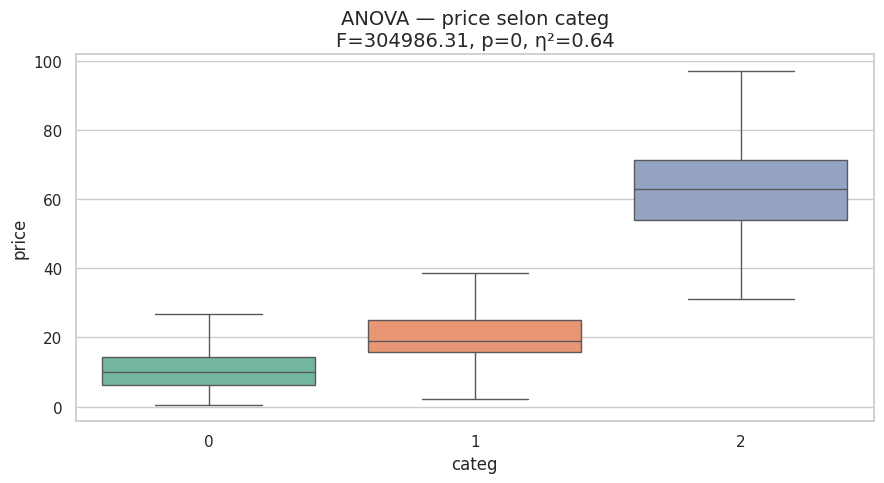

In [ ]:
# ============================
# ANOVA + ETA² — QUALI / QUANTI
# ============================

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

X = "categ"      # variable qualitative
Y = "price"      # variable quantitative
df = df_tf.copy()

# 1️⃣ Nettoyage et typage
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")

# 2️⃣ Préparation des groupes
groupes = [df.loc[df[X] == m, Y].values for m in df[X].cat.categories]

# 3️⃣ Test ANOVA
F, p = stats.f_oneway(*groupes)
print(f"Test ANOVA sur {Y} selon {X}")
print(f"F = {F:.3f}, p = {p:.3g}")

# 4️⃣ Calcul de l’Eta²
y = df[Y]
y_mean = y.mean()
SCE = sum([len(g)*(g.mean()-y_mean)**2 for g in groupes])
SCT = ((y - y_mean)**2).sum()
eta2 = SCE / SCT
print(f"→ Eta² = {eta2:.3f}")

# 5️⃣ Interprétation
if p < 0.05:
    print("→ Différence significative entre au moins deux groupes.")
else:
    print("→ Aucune différence significative détectée.")

# 6️⃣ Visualisation
plt.figure(figsize=(9,5))
sns.boxplot(data=df, x=X, y=Y, palette="Set2", showfliers=False)
plt.title(f"ANOVA — {Y} selon {X}\nF={F:.2f}, p={p:.3g}, η²={eta2:.2f}")
plt.tight_layout()
plt.show()


Khi² = 81.869, ddl = 2, p = 1.67e-18
Cramer’s V = 0.016
→ Association significative entre les deux variables.


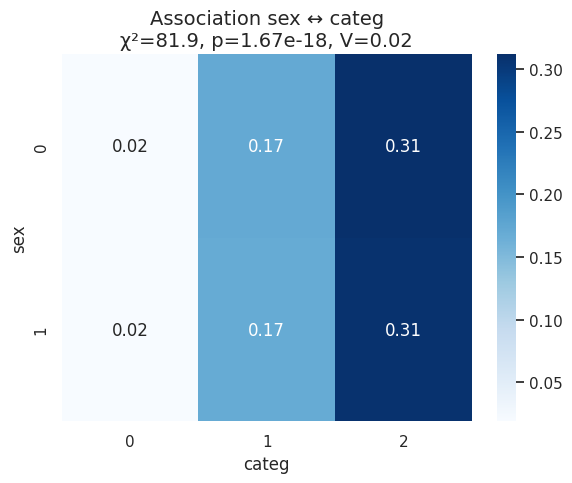

In [ ]:
# ============================
# KHI-2 + CRAMER’S V — QUALI / QUALI
# ============================

from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

X = "sex"       # variable qualitative 1
Y = "categ"     # variable qualitative 2
df = df_tf.copy()

# 1️⃣ Nettoyage
df = df[[X, Y]].dropna()
df[X] = df[X].astype("category")
df[Y] = df[Y].astype("category")

# 2️⃣ Table de contingence
ct = pd.crosstab(df[X], df[Y])

# 3️⃣ Test du Khi-2
chi2, p, dof, expected = stats.chi2_contingency(ct)
n = ct.to_numpy().sum()
r, c = ct.shape
cramers_v = np.sqrt(chi2 / (n * (min(r, c) - 1)))

# 4️⃣ Résultats
print(f"Khi² = {chi2:.3f}, ddl = {dof}, p = {p:.3g}")
print(f"Cramer’s V = {cramers_v:.3f}")

if p < 0.05:
    print("→ Association significative entre les deux variables.")
else:
    print("→ Aucune association significative détectée.")

# 5️⃣ Visualisation
contrib = (ct - expected)**2 / expected
rel = contrib / contrib.to_numpy().sum()

plt.figure(figsize=(6,5))
sns.heatmap(rel, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Association {X} ↔ {Y}\nχ²={chi2:.1f}, p={p:.3g}, V={cramers_v:.2f}")
plt.tight_layout()
plt.show()
